In [44]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_tunneling.workflows import run_bound_states, run_tdse, run_field_scan
from quantum_tunneling.viz import create_wavefunction_animation
from quantum_tunneling.fields import apply_field
import matplotlib.animation as animation

from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d%H%M')


In [45]:
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 10.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 10.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": -5.0}},
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}
pot_key = "cusp"
state_index = 3
L=100.0 #50
cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": L, "N": 1200},
    "solver": {"k": 12, "hbar": 1.0, "m": 1.0},
    "tdse": {
        "dt": 0.002,
        "duration": 64.0,
        "record_interval": 25,
        "hbar": 1.0,
        "m": 1.0,
        "F": 1.5,
        "cap": {"x_start": L-10, "x_end": L-0.5, "strength": 30.0, "power": 2},
    },
}
cfg
# V0 10 F 1.5 # 
# V0 1 F 0.1

{'potential': {'kind': 'cusp', 'params': {'V0': 10.0, 'alpha': 0.5}},
 'grid': {'L': 100.0, 'N': 1200},
 'solver': {'k': 12, 'hbar': 1.0, 'm': 1.0},
 'tdse': {'dt': 0.002,
  'duration': 64.0,
  'record_interval': 25,
  'hbar': 1.0,
  'm': 1.0,
  'F': 1.5,
  'cap': {'x_start': 90.0, 'x_end': 99.5, 'strength': 30.0, 'power': 2}}}

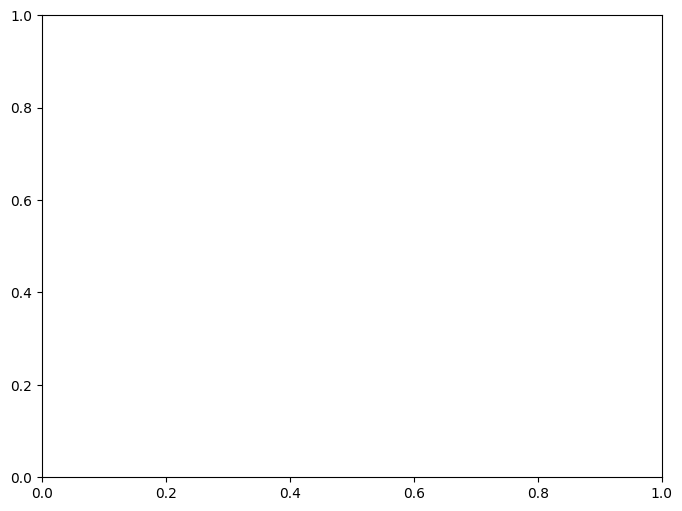

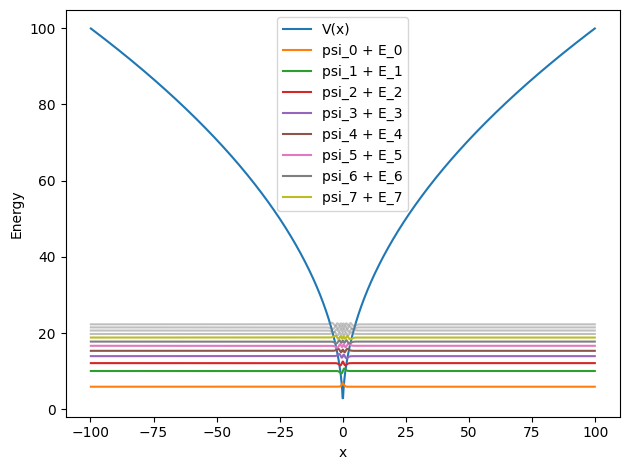

1.5 11.07410491257285 16.666620370306013


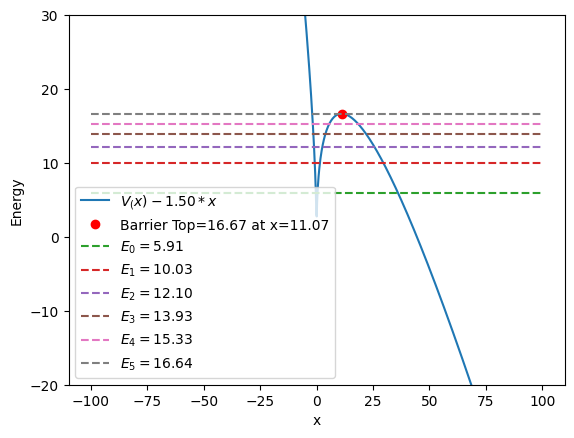

Highest bound state below barrier top: n=6, E=17.7480


In [46]:
# solve bound states for the given potential(without field)
from quantum_tunneling.viz import plot_potential_and_states
res = run_bound_states(cfg)
E = res["E"]
x = res['x']
Vx = res['Vx']
psi = res['psi']
dx = res['dx']

fig, ax = plt.subplots(figsize=(8, 6))
scale = 40

plot_potential_and_states(x, Vx, E, psi, scale=0.8)
plt.show()

# plot tilted potential

F= cfg['tdse']['F']
from quantum_tunneling.fields import barrier_top
Vtilt = apply_field(res['Vx'], x, F)
idx = barrier_top(x, Vtilt,x_min=0)
xtop, vtop = x[idx], Vtilt[idx]
print(F, xtop, vtop)
plt.plot(x, Vtilt, label=f'$V_(x)-{F:.2f}*x$')
plt.plot(xtop, vtop, 'ro', label=f'Barrier Top={vtop:.2f} at x={xtop:.2f}')
highest_bound_state = 0

for n, energy in enumerate(E):
    highest_bound_state = n
    if energy < vtop:
        plt.hlines(energy, x[0], x[-1], colors='C'+str(n+2), linestyles='dashed', label=f'$E_{n}={energy:.2f}$')
    else:
        break
plt.ylim(-20, 30)
plt.xlabel('x')
plt.ylabel('Energy')
plt.legend()
plt.show()

print(f'Highest bound state below barrier top: n={highest_bound_state}, E={E[highest_bound_state]:.4f}')


In [47]:
# use the selected bound state as the initial state and run TDSE with the potential + field
td = run_tdse(cfg, res, state_index=state_index)

# results from TDSE simulation

frames = td['frames']
print(f"Total recorded frames: {len(frames)}")

survival = td['survival']
tunneling_flux = td['tunneling_flux']
barrier_info = td['barrier_info']
x1 = td['x1']
x2 = td['x2']
times = [f['t'] for f in frames]

scale = 40
T_WKB = barrier_info.get('tunneling_time_wkb', None)



Total recorded frames: 1281


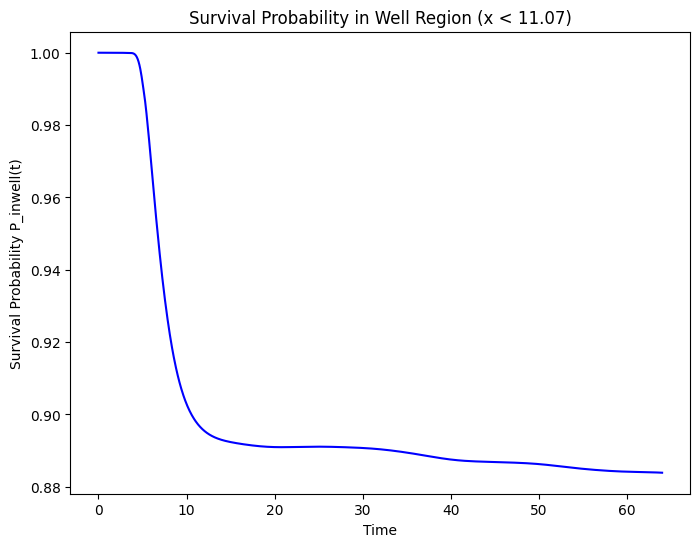

Estimated decay rate from last 640 frames: 0.0002201422482195


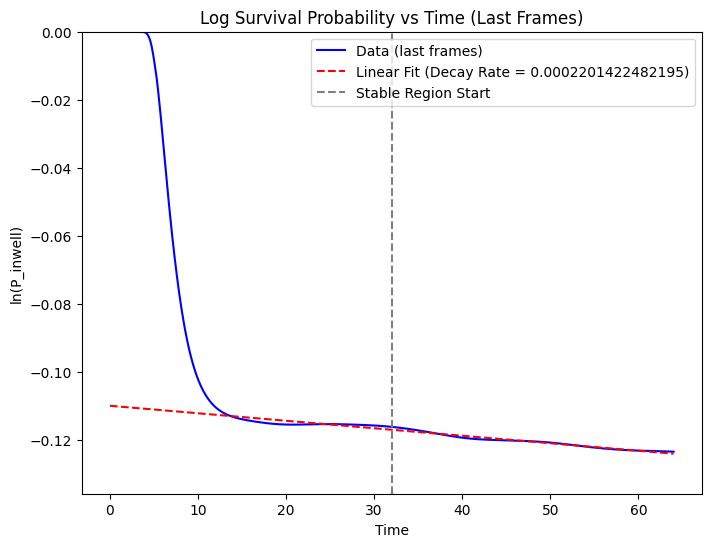

In [48]:
# survival probability is defined by integrating the probability density over the initial well region
# Plot survival probability over time
x_barrier_top = barrier_info['barrier_top'][0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(times, survival, 'b-')
ax.set_title(f'Survival Probability in Well Region (x < {x_barrier_top:.2f})')
ax.set_xlabel('Time')
ax.set_ylabel('Survival Probability P_inwell(t)')
plt.show()

# since we are actually using the eigenstate of the static potential as initial
# state, not the eigenstate of the tilted potential, there will be some initial
# drop in survival probability due to this mismatch
# so we can take last few frames to estimate the decay rate
last_n = int(len(frames)*0.5)

P_inwell_stable = survival[-last_n:]
times_stable = times[-last_n:]
ln_P = np.log(P_inwell_stable)

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(times_stable, ln_P)
decay_rate = -slope

print(f"Estimated decay rate from last {last_n} frames: {decay_rate:.16f}")
plt.figure(figsize=(8,6))
plt.ylim(min(ln_P)*1.1, 0)
plt.plot(times, np.log(survival), 'b-', label='Data (last frames)')
plt.plot(times, intercept + slope * np.array(times), 'r--', label=f'Linear Fit (Decay Rate = {decay_rate:.16f})')
# draw a vertical line to indicate where the stable region starts
plt.axvline(times_stable[0], color='gray', linestyle='--', label='Stable Region Start')
plt.title('Log Survival Probability vs Time (Last Frames)')
plt.xlabel('Time')
plt.ylabel('ln(P_inwell)')
plt.legend()
plt.show()


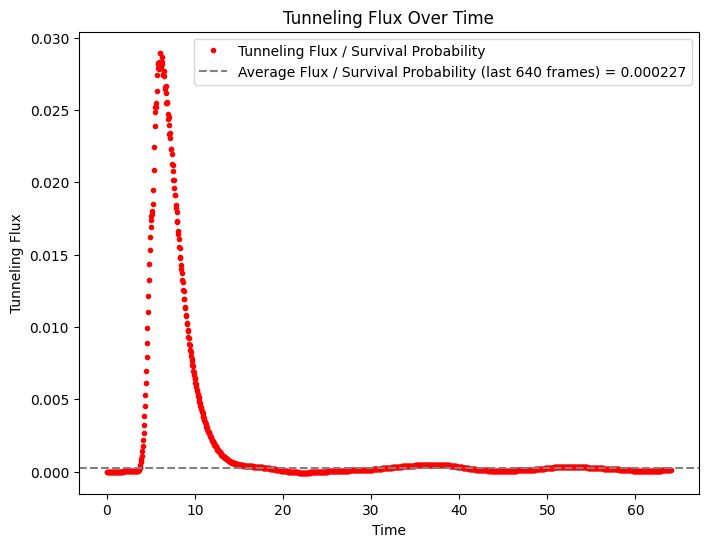

In [49]:
# plot tunneling flux over time
plt.figure(figsize=(8,6))
plt.plot(times, tunneling_flux/survival, 'r.', label='Tunneling Flux / Survival Probability')
# compute the average tunneling flux in the stable region
average_flux = np.mean(tunneling_flux[-last_n:] / survival[-last_n:])
plt.axhline(average_flux, color='gray', linestyle='--', label=f'Average Flux / Survival Probability (last {last_n} frames) = {average_flux:.6f}')
plt.legend()
plt.title('Tunneling Flux Over Time')
plt.xlabel('Time')
plt.ylabel('Tunneling Flux')
plt.show()

In [50]:
# Create animation
E = res['E'][state_index]
def update(frame):
    ax.clear()
    ax.set_title(f'Time: {frame["t"]:.3f} | Field: {cfg["tdse"]["F"]}')
    ax.plot(x, Vtilt, 'k-', label='Tilted Potential')
    ax.axhline(E, color='r', linestyle='--', label=f'State Energy $E_{state_index}={E:.2f}$')
    ax.axhline(E+scale, color='gray', linestyle=':', label='scale reference "1"')
    
    psi = frame['psi']
    prob_density = np.abs(psi)**2
    psi_real = np.real(psi)
    ax.plot(x,E+ psi_real * scale, 'g-', label='Wavefunction (scaled)')
    psi_imag = np.imag(psi)
    ax.plot(x, E + psi_imag * scale, 'm-', label='Wavefunction Imag (scaled)')
    ax.plot(x, E + prob_density * scale, 'b-', label='Probability Density (scaled)')
    
    # draw cap region
    cap = cfg['tdse']['cap']
    ax.axvspan(cap['x_start'], cap['x_end'], color='orange', alpha=0.3, label='Absorbing Cap')
    ax.set_ylim(-25, 50)
    ax.set_xlim(-7, cfg["grid"]["L"])
    ax.set_xlabel('x')
    ax.set_ylabel('Energy / Probability Density')
    ax.legend()
ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)
ani.save(f'time_evolution_V0_{potentials[pot_key]["params"]["V0"]}_F_{cfg["tdse"]["F"]}_state_{state_index}_{timestamp}.gif', writer='pillow', fps=30)


In [51]:
# Let's investigate the deviations from WKB predictions due to exotic potential features by drawing lnGamma_TDSE vs S(E)
from quantum_tunneling.wkb import barrier_check
lnGammas = []
S_Es = []
for i in range(highest_bound_state):
    print(f"Analyzing state n={i}")
    # run TDSE for each bound state
    cfg_tdse = cfg.copy()
    tdse_res = run_tdse(cfg_tdse, res, state_index=i)
    survival = tdse_res['survival']
    
    
    P_inwell_stable = survival[-last_n:]
    ln_P = np.log(P_inwell_stable)

    slope, intercept, r_value, p_value, std_err = linregress(times_stable, ln_P)
    decay_rate = -slope
    print(f"  Decay rate for state n: Gamma_{i} = {decay_rate:.16f}")
    # WKB action S(E)
    E_state = res['E'][i]
    barrier_info = barrier_check(x, Vtilt, float(res["E"][i]), x_min=0.0)
    S_E = barrier_info['S']
    print(f"  WKB Action S(E) for state n={i}: {S_E:.6f}")
    lnGammas.append(np.log(decay_rate))
    S_Es.append(S_E)


Analyzing state n=0
  Decay rate for state n: Gamma_0 = 0.0000000014797053
  WKB Action S(E) for state n=0: 129.925186
Analyzing state n=1
  Decay rate for state n: Gamma_1 = 0.0000000530027458
  WKB Action S(E) for state n=1: 80.149073
Analyzing state n=2
  Decay rate for state n: Gamma_2 = 0.0000151659498159
  WKB Action S(E) for state n=2: 55.154242
Analyzing state n=3
  Decay rate for state n: Gamma_3 = 0.0002201422482195
  WKB Action S(E) for state n=3: 33.019767
Analyzing state n=4
  Decay rate for state n: Gamma_4 = 0.0004957173262967
  WKB Action S(E) for state n=4: 16.171974
Analyzing state n=5
  Decay rate for state n: Gamma_5 = 0.0000070916608490
  WKB Action S(E) for state n=5: 0.265812


Linear fit of ln(Gamma) vs S(E): slope=-0.090318, intercept=-7.941076, r_value=-0.864542


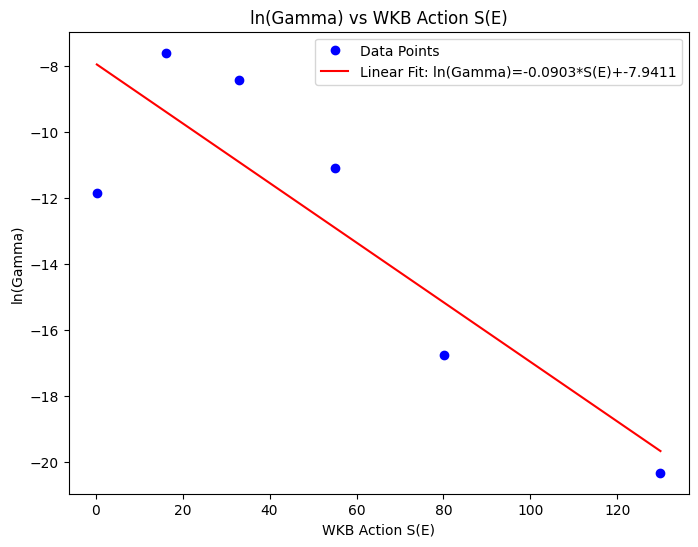

In [52]:

# linear fit of lnGamma vs S(E)
slope, intercept, r_value, p_value, std_err = linregress(S_Es, lnGammas)
print(f"Linear fit of ln(Gamma) vs S(E): slope={slope:.6f}, intercept={intercept:.6f}, r_value={r_value:.6f}")
# 画出图像，并显示拟合直线，标注截距、斜率
plt.figure(figsize=(8,6))
plt.plot(S_Es, lnGammas, 'bo', label='Data Points')
plt.plot(S_Es, intercept + slope * np.array(S_Es), 'r-', label=f'Linear Fit: ln(Gamma)={slope:.4f}*S(E)+{intercept:.4f}')
plt.title('ln(Gamma) vs WKB Action S(E)')
plt.xlabel('WKB Action S(E)')
plt.ylabel('ln(Gamma)')
plt.legend()
plt.show()

    
    

## Notes
- Fit an exponential to `survival` vs time to estimate escape rate Γ.
- Increase `duration` or reduce `dt` for accuracy; ensure CAP starts outside the initial localization region.
- Swap `pot_key` and `F` to probe how exotic shapes tilt and affect escape.